In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tqdm 

from itertools import combinations


In [2]:
"""
BLACK BOX: This cell is a black box from Lovish that reads/parses the\
beneficiary data and returns arrays corresponding to beneficiary IDs,\ 
cluster assignments, transition probs, whittle indices
"""

def loadBeneficiaryData():
  """
  This function cd's to the folder where the relevant data pickle files are \
  stored. Reads and returns:

  rmab_grou_probs:
    Numpy matrix storing transition probabilites of size Nx2x2x2 with axes \
    num_beneficiariesX action X start_state x end_state
    N: num of beneficiaries
    action: 0= passive, 1=active
    start/end state: 0= Not engaging 1=Engaging

  rmab_group_whittle_indices:
    Numpy array of size Nx2. i-th entry corresponds to the whittle indices\
    for states [NE, E] for beneficiary i
  
  engagement_matrix: 
    Dictionary with keys: ['rmab', 'round_robin', 'control']. 
    engagement_matrix[key] is a NxL numpy matrix storing binary engagement data
    N=num of beneficiaries
    L=num of timesteps  
  """
#   from google.colab import drive
#   drive.mount('/content/drive')
  '''
  This line reads files present in my drive. For it to work on your system,
  please make sure to have the necessary files present in your cwd.
  '''
  ## Loading Whittle Policy related files
  aug_states = []
  for i in range(6):
      if i % 2 == 0:
          aug_states.append('E{}'.format(i // 2))
      else:
          aug_states.append('NE{}'.format(i // 2))

  CONFIG = {
      "problem": {
          "orig_states": ['E', 'NE'],
          "states": aug_states + ['E', 'NE'],
          "actions": ["A", "I"],
      },
      "time_step": 7,
      "gamma": 0.99
  }

#   %cd drive/My\ Drive/ARMMAN/code/ 
  with open('policy_dump.pkl', 'rb') as fr:
    pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
  fr.close()

  #engagement_matrix_file='full_matrix.pkl'
  engagement_matrix_file='full_matrix_week11_end.pkl'
  with open(engagement_matrix_file, 'rb') as fr:
    engagement_matrix = pickle.load(fr)
  fr.close()

  cluster_assignments = cls.predict(pilot_static_features)

  rmab_group_results = pd.read_csv('outputs/pilot_outputs/rmab_pilot.csv')
  rmab_user_ids = rmab_group_results['user_id'].to_list()

  rmab_group_probs, rmab_group_whittle_indices = [], []

  for idx, user_id in enumerate(rmab_user_ids):
    locate_idx = np.where(pilot_user_ids == user_id)[0][0]
    curr_cluster = cluster_assignments[locate_idx]
    whittle_indices = m_values[curr_cluster]

    start_state = rmab_group_results[rmab_group_results['user_id'] == user_id]['start_state'].item()

    t_probs = np.zeros((len(CONFIG['problem']['states']), len(CONFIG['problem']['states']), len(CONFIG['problem']['actions'])))
    two_state_probs = np.zeros((2, 2, 2))
    for i in range(two_state_probs.shape[0]):
      for j in range(two_state_probs.shape[1]):
        for k in range(two_state_probs.shape[2]):
          s = CONFIG['problem']['orig_states'][i]
          s_prime = CONFIG['problem']['orig_states'][j]
          a = CONFIG['problem']['actions'][k]
          #two_state_probs[i, j, k] = cluster_transition_probabilities.loc[cluster_transition_probabilities['cluster']==curr_cluster, "P(" + s + ", " + a + ", " + s_prime + ")"]
          two_state_probs[k, int(1-i), int(1-j)] = cluster_transition_probabilities.loc[cluster_transition_probabilities['cluster']==curr_cluster, "P(" + s + ", " + a + ", " + s_prime + ")"]
          # The indices are adjusted to return transition matrix in the format T[action, start_state, end_state] where state=0 is bad state and state=1 is good state
          
    t_probs[0 : 2, 2 : 4, 0] = two_state_probs[0, :, :]
    t_probs[2 : 4, 4 : 6, 0] = two_state_probs[0, :, :]
    t_probs[4 : 6, 6 : 8, 0] = two_state_probs[0, :, :]
    t_probs[6 : 8, 6 : 8, 0] = two_state_probs[0, :, :]

    t_probs[0 : 2, 2 : 4, 1] = two_state_probs[0, :, :]
    t_probs[2 : 4, 4 : 6, 1] = two_state_probs[0, :, :]
    t_probs[4 : 6, 6 : 8, 1] = two_state_probs[0, :, :]
    t_probs[6 : 8, 0 : 2, 1] = two_state_probs[1, :, :]

    rmab_group_probs.append(two_state_probs)
    user_whittle_idx = rmab_group_results[rmab_group_results['user_id'] == user_id]['whittle_index'].item()
    #rmab_group_whittle_indices.append(user_whittle_idx)
    rmab_group_whittle_indices.append([whittle_indices[-1],whittle_indices[-2]]) ### whittle_indeces[-1] is for NE and whittle_indices[-2] is for E

  rmab_group_probs = np.array(rmab_group_probs)
  rmab_group_whittle_indices = np.array(rmab_group_whittle_indices)
  return rmab_group_probs, rmab_group_whittle_indices, engagement_matrix
T_data,w, engagement_matrix= loadBeneficiaryData()


def get_reward(state, action, m):
    """
    Helper function for plan2() function below
    """
    if state[0] == "L":
        reward = 1.0
    else:
        reward = -1.0
    if action == 'N':
        reward += m

    return reward

def convertAxis(T):
    '''
    convert T matrix from format: a, s, s' (where s=0 is bad state) --> 
                                  s, s', a (where s=0 is good state) 
    This function is needed because most of my simulator code uses the former
    format while the whittleIndex function below is coded up using the latter. 
    '''
    P=np.zeros_like(T)
    for a in range(2):
      for s in range(2):
        for ss in range(2):
          P[1-s,1-ss,a]=T[a,s,ss]
    return P

def getWhittleIndex(two_state_probs, sleeping_constraint = True ):
    '''
    Function that generates whittle indices given transition probabilities. 
    Inputs: 
      two_state_probs: Transition probability matrix with axes,
                      action, starting_state, final_state. 
                      Here State=0 means engaging state
      sleeping_constraint: If True, considers the frequency constraints 
                          (and the modified MDP)
    Outputs:
      A list of len 2, corresponding to whittle indices of [NE, E] states.
    '''
    two_state_probs=convertAxis(two_state_probs)

    aug_states = []
    for i in range(6):
        if i % 2 == 0:
            aug_states.append('L{}'.format(i // 2))
        else:
            aug_states.append('H{}'.format(i // 2))

    if sleeping_constraint:
        local_CONFIG = {
            'problem': {
                "orig_states": ['L', 'H'],
                "states": aug_states + ['L', 'H'],
                "actions": ["N", "I"],
            },
            "time_step": 7,
            "gamma": 0.99,
        }
    else:
        local_CONFIG = {
            'problem': {
                "orig_states": ['L', 'H'],
                "states": ['L', 'H'],
                "actions": ["N", "I"],
            },
            "time_step": 7,
            "gamma": 0.99,
        }

    v_values = np.zeros(len(local_CONFIG['problem']['states']))
    q_values = np.zeros((len(local_CONFIG['problem']['states']), \
                         len(local_CONFIG['problem']['actions'])))
    high_m_values = 1 * np.ones(len(local_CONFIG['problem']['states']))
    low_m_values = -1 * np.ones(len(local_CONFIG['problem']['states']))

    t_probs = np.zeros((len(local_CONFIG['problem']['states']), \
                        len(local_CONFIG['problem']['states']), \
                        len(local_CONFIG['problem']['actions'])))

    if sleeping_constraint:    
        t_probs[0 : 2, 2 : 4, 0] = two_state_probs[:, :, 0]
        t_probs[2 : 4, 4 : 6, 0] = two_state_probs[:, :, 0]
        t_probs[4 : 6, 6 : 8, 0] = two_state_probs[:, :, 0]
        t_probs[6 : 8, 6 : 8, 0] = two_state_probs[:, :, 0]

        t_probs[0 : 2, 2 : 4, 1] = two_state_probs[:, :, 0]
        t_probs[2 : 4, 4 : 6, 1] = two_state_probs[:, :, 0]
        t_probs[4 : 6, 6 : 8, 1] = two_state_probs[:, :, 0]
        t_probs[6 : 8, 0 : 2, 1] = two_state_probs[:, :, 1]
    else:
        t_probs = two_state_probs

    max_q_diff = np.inf
    prev_m_values, m_values = None, None
    while max_q_diff > 1e-5:
        prev_m_values = m_values
        m_values = (low_m_values + high_m_values) / 2
        if type(prev_m_values) != type(None) and \
        abs(prev_m_values - m_values).max() < 1e-20:
            break
        max_q_diff = 0
        v_values = np.zeros((len(local_CONFIG['problem']['states'])))
        q_values = np.zeros((len(local_CONFIG['problem']['states']), \
                             len(local_CONFIG['problem']['actions'])))
        delta = np.inf
        while delta > 0.0001:
            delta = 0
            for i in range(t_probs.shape[0]):
                v = v_values[i]
                v_a = np.zeros((t_probs.shape[2],))
                for k in range(v_a.shape[0]):
                    for j in range(t_probs.shape[1]):
                        v_a[k] += t_probs[i, j, k] * \
                        (get_reward(local_CONFIG['problem']['states'][i], \
                                    local_CONFIG['problem']['actions'][k], \
                                    m_values[i]) + local_CONFIG["gamma"] * \
                         v_values[j])

                v_values[i] = np.max(v_a)
                delta = max([delta, abs(v_values[i] - v)])

        state_idx = -1
        for state in range(q_values.shape[0]):
            for action in range(q_values.shape[1]):
                for next_state in range(q_values.shape[0]):
                    q_values[state, action] += \
                    t_probs[state, next_state, action] * \
                    (get_reward(local_CONFIG['problem']['states'][state], \
                                local_CONFIG['problem']['actions'][action], \
                                m_values[state]) + local_CONFIG["gamma"] * \
                     v_values[next_state])
            # print(state, q_values[cluster, state, 0], \
            #q_values[cluster, state, 1])

        for state in range(q_values.shape[0]):
            if abs(q_values[state, 1] - q_values[state, 0]) > max_q_diff:
                state_idx = state
                max_q_diff = abs(q_values[state, 1] - q_values[state, 0])

        # print(q_values)
        # print(low_m_values, high_m_values)
        if max_q_diff > 1e-5 and q_values[state_idx, 0] < q_values[state_idx, 1]:
            low_m_values[state_idx] = m_values[state_idx]
        elif max_q_diff > 1e-5 and q_values[state_idx, 0] > q_values[state_idx, 1]:
            high_m_values[state_idx] = m_values[state_idx]

        # print(low_m_values, high_m_values, state_idx)
        # ipdb.set_trace()
    
    m_values = (low_m_values + high_m_values) / 2

    #return q_values, m_values
    return [m_values[-1], m_values[-2]]

In [3]:
print(engagement_matrix)

{'rmab': array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 1, 0, 0]]), 'round_robin': array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]]), 'control': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]])}


In [4]:
"""This cell contains all utils-like helper functions"""

def getTopk(a, k):
  '''
  Returns indices of top k elements in array a
  '''
  a=np.array(a)
  return a.argsort()[-k:][::-1]

def verify_T_matrix(T):
    '''
    Checks whether it satisfies the natural constraints assumed in the problem \
    (active is better than passive etc.)
    '''
    valid = True
    valid &= T[0, 0, 1] <= T[0, 1, 1] #non-oscillate condition
    valid &= T[1, 0, 1] <= T[1, 1, 1] #must be true for active as well
    valid &= T[0, 1, 1] <= T[1, 1, 1] #action has positive "maintenance" value
    valid &= T[0, 0, 1] <= T[1, 0, 1] #action has non-negative "influence" value
    return valid

def generateRandomTmatrix(N):

    """
    Generates a Nx2x2x2 T matrix indexed as: \
    T[beneficiary_number][action][current_state][next_state]
    action=0 denotes passive action, a=1 is active action
    """
        
    T=np.zeros((N,2,2,2))
    for i in range(N):
        p_pass_01, p_pass_11, p_act_01, p_act_11=np.random.uniform(size=4)
        T[i,0]=np.array([[1-p_pass_01, p_pass_01],[1-p_pass_11, p_pass_11]])
        T[i,1]=np.array([[1-p_act_01, p_act_01],[1-p_act_11, p_act_11]])
    return T  

def barPlot(labels, values, errors, ylabel='', title=None, figsize=(8,3.5)):
    """
    Standard matplotlib bar plot code
    """
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height.
        """
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    colors=['#002222', '#335577', '#5599cc', '#bbddff', '#ddeeff', '#882222',\
            '#bb2222','#dd2222', '#ff2222' ]
    x = np.arange(len(labels))  # the label locations
    width = 0.65  # the width of the bars
    fig, ax = plt.subplots(figsize=figsize)
    for i in range(len(values)):
      rects1=ax.bar(x[i], np.round(values[i], decimals=2) , width, \
                    yerr=errors[i], label=labels[i], align='center', \
                    color=colors[i], edgecolor='k', capsize=4)
      autolabel(rects1) 
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.01),ncol=2)  
    ax.set_ylabel(ylabel, fontsize=20)
    if title is not None:
        ax.set_title(title, fontsize=16)   
    ax.set_xticks(x)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=14)
    ax.set_ylim(top=max(values)*1.1)
    autolabel(rects1)       
    plt.tight_layout() 
    #plt.savefig(fname)
    plt.show()


def plotIB(simulated_rewards, policies, policy_names,
           lower_pol=0, upper_pol=3, policies_to_plot=None):

    """
    Computes intervention benefit from raw rewards, computes errorbars and 
    generates bar plots 
    Inputs: 
      simulated_rewards: A matrix of dimensions num_trials X num_policies
      policies: Policies which are to be plotted. 
      policy_names: Dictionary which stores policy names as value with policy
                   number as key.
      lower_pol: Index 0 is policy 0 (lower baseline). 
      upper_pol: Policy 3, RR (Round Robin), is the default upper baseline
      policies_to_plot: Policies to include in the plot. 
                  If None, then defaults to policies.
    """
    lower_reward=np.mean(simulated_rewards[:,policies.index(lower_pol)])
    upper_reward=np.mean(simulated_rewards[:,policies.index(upper_pol)])
    lower_error=(np.std(simulated_rewards[:,policies.index(lower_pol)]))\
                  /(np.sqrt(len(simulated_rewards)))
    upper_error=(np.std(simulated_rewards[:,policies.index(upper_pol)]))\
                  /(np.sqrt(len(simulated_rewards)))
    if policies_to_plot is None: 
      policies_to_plot=policies
    
    ibs={}
    errors_rewards={}
    errors_ibs={}

    for pol in policies_to_plot:
      reward_gain=np.mean(simulated_rewards[:,policies.index(pol)])-lower_reward
      ibs[pol]=(100.*(reward_gain))/(upper_reward-lower_reward)
      errors_rewards[pol]=(np.std(simulated_rewards[:,policies.index(pol)]))\
                            /(np.sqrt(len(simulated_rewards)))
      errors_ibs[pol]=((errors_rewards[pol]+lower_error)/(reward_gain) \
              +(upper_error+lower_error)/(upper_reward-lower_reward))*ibs[pol]

    barPlot([policy_names[pol] for pol in policies_to_plot], \
            [ibs[pol] for pol in policies_to_plot], \
            [errors_ibs[pol] for pol in policies_to_plot], \
            ylabel='Intervention benefit')

    return ibs, errors_ibs

    
def getCounterExampleTmatrix(N, badf):
  """
  Generates transition matrices that lead to poor performance of myopic policy
  Inputs: 
    N: Num of beneficiaries
    badf: Fraction of bad (non-recoverable) beneficiaries. Other (1-badf) are \
    self-correcting beneficiaries.
  Output: 
    T: Transition matrix of size Nx2x2x2 with axes denoting [num_benficiary]x\
      [action][start_state][end_state]

  """

  shift=0.05                        ### Magnitude of random perturbation   
  T=np.zeros((N,2,2,2))
  type1= [[[0.97, 0.03],
            [0.03, 0.97]],

          [[0.96, 0.04],
            [0.01, 0.99]]]          ### Bad (non-recoverable) beneficiary
                                    ### Whittle is supposed to select this
  
  type2 = [[[0.25, 0.75],
              [0.03, 0.97]],
          [[0.23, 0.77],
            [0.01     , 0.99 ]]]    ### Good (self-healing) beneficiary
                                    ### Mypoic is supposed to fall for this
  
  types=[type1, type2]
  ### Select which beneficiary should be which type
  type_choices=np.random.choice([0, 1],p=[badf/100., 1-(badf/100.)], size=N, \
                                replace=True)
  
  ### For each beneficiary, add random perturbation to make all T's unique
  for i in range(N):
    
      T[i]=np.copy(np.array(types[int(type_choices[i])]))
      # add benefit_act_00 to benefit_act_11 to guarantee the p11>p01 condition
      
      benefit_act_00=np.random.uniform(low=0., high=shift) 
      # will subtract from prob of staying 0,0
      benefit_act_11= benefit_act_00 + np.random.uniform(low=0., high=shift) 
      # will add to prob of staying 1,1
      penalty_pass_11=np.random.uniform(low=0., high=shift)
      # will sub from prob of staying 1,1
      penalty_pass_00=penalty_pass_11+np.random.uniform(low=0., high=shift) 
      # will add to prob of staying 0,0


      T[i][1][0][0]= max(0, T[i][1][0][0] - benefit_act_00)            
      T[i][1][1][1]= min(1, T[i][1][1][1] + benefit_act_11)            
      
      T[i][0][0][0]= min(1, T[i][0][0][0] + penalty_pass_00)            
      T[i][0][1][1]= max(0, T[i][0][1][1] - penalty_pass_11)  
      
      T[i][0][0][1]=   1- T[i][0][0][0]          
      T[i][0][1][0]=   1- T[i][0][1][1]
      
      T[i][1][0][1]=   1- T[i][1][0][0]          
      T[i][1][1][0]=   1- T[i][1][1][1]
  
  return T

In [5]:
def takeActions(states, T, actions):
  '''
  Simulates random transitions by flipping coins for each beneficiaries and \
  updating their states given previous states and actions taken

  Inputs: 
  states: A vector of size N with binary values {0,1} respresenting the states\
          of beneficiaries
  T: Transition matrix of size Nx2x2x2 (num_beneficiaries x action x \
          starting_state x ending_state)
  actions: A vector of size N with binary values {0,1} representing action \
          chosen for each beneficiary

  Outputs:
  next_states:  A vector of size N with binary values {0,1} respresenting the\
          *next* states of beneficiaries, determined using coin tosses
  '''

  next_states=np.random.binomial(1, T[np.arange(T.shape[0]),actions.astype(int)\
                                      , states,1])
  return next_states


def getActions(states, T,k, policy=0, timestep=None,w=None, available_arms=None\
               , sleeping_constraint=True):
  '''
  Computes actions to be taken according to the given policy. 
  See below for more info on policy map

  Inputs: 
    states: A vector of size N with binary values {0,1} respresenting the \
        states of beneficiaries
    T: Transition matrix of size Nx2x2x2 \
        (num_beneficiaries x action x starting_state x ending_state)
    k: Intervention budget. Assumed to be between 0 and num_of_beneficiaries
    policy: Policy to implement. Dictionary: \
        {0: No interventions, 1: intervene on all, 2: random, 3: round-robin,\
        4: myopic, 5: whittle}
    timestep: timestep at which function is called (relevant for round robin)
    w: Array of size Nx2 storing the whittle indices of arms when they are \
      available. Indexed as w[beneficiary_idx, state] with state=0 => NE state.
  available_arms: An array of size N with binary values {0,1}, where 0 denotes\
      sleeping arm and 1 denotes available arm. 
  sleeping_constraint: Boolean indicating whether to impose frequency constraint
  
  Outputs:
    actions: A vector of size N with binary values {0,1} representing action \
    chosen for each beneficiary  
  '''
  SOME_LARGE_NUMBER=10000
  N= states.shape[0]
  if policy==0: 
    ## No interventions
    return np.zeros(N)
  if policy==1: 
    ## Intervene on everybody
    if sleeping_constraint:
      return np.logical_and(np.ones(N), available_arms)+0   # with constraint
    else:
      return np.ones(N)                                     # without constraint
  if policy==2:
    ## select k arms at random
    actions=np.zeros(N)
    if sleeping_constraint:
      actions[np.random.choice(np.where(available_arms)[0],                    \
                          size=min(k,np.sum(available_arms[available_arms>0])),\
                          replace=False)]=1         # with constraint
    else:
      actions[np.random.choice(np.arange(N), size=k, replace=False)]=1         \
                                                    # without constraint
    return actions
  if policy==3:
    ## select k arms in a round robin fashion
    actions=np.zeros(N)
    if sleeping_constraint:
      if np.sum(available_arms)<=k:
        actions[np.where(available_arms)[0]]=1
      else:
        actions[[(timestep*k+i)%N for i in range(k)]]=1
        '''This is assuming that because more arms are available than required,\
        the arms that we would have pulled otherwise would always be available'''
    else:
      actions[[(timestep*k+i)%N for i in range(k)]]=1
    return actions

  if policy==4:
    ## select k arms maximizing myopic rewards
    actions=np.zeros(N)
    myopic_rewards=T[np.arange(N), 1, states, 1]-T[np.arange(N), 0, states, 1]
    if sleeping_constraint:
      myopic_rewards[np.where(1-available_arms)]=-SOME_LARGE_NUMBER
      ## This is preclude sleeping arms from possibility of selection. 
      ## Setting it to -infty can lead to numerical errors
      top_k_myopic_rewards=getTopk(myopic_rewards, \
                                   min(k, int(np.sum(available_arms))))
    else:
      top_k_myopic_rewards=getTopk(myopic_rewards, k)
    top_k_positive_myopic_rewards=np.array([idx for idx in top_k_myopic_rewards\
                                            if myopic_rewards[idx]>0])
    ## Pull only arms with positive mypoic value
    if len(top_k_positive_myopic_rewards)>0:
      actions[top_k_positive_myopic_rewards]=1
    return actions

  if policy==5:
    ## select k arms according to whittle indices
    actions=np.zeros(N)
    whittle_indices=w[np.arange(N), states]
    if sleeping_constraint:
      whittle_indices[np.where(1-available_arms)]=-SOME_LARGE_NUMBER 
      ## This is preclude sleeping arms from possibility of selection. 
      ## Setting it to -infty can lead to numerical errors
      top_k_whittle=getTopk(whittle_indices, min(k,int(np.sum(available_arms))))
    else:
      top_k_whittle=getTopk(whittle_indices, k)
    top_k_positive_whittle=np.array([idx for idx in top_k_whittle if \
                                     whittle_indices[idx]>0])
    ## Pull only arms with positive whittle indices
    if len(top_k_positive_whittle)>0:
      actions[top_k_positive_whittle]=1
    return actions



In [6]:
def runSimulation(args, T=None,w=None, sleeping_constraint=True,\
                  counterExample=False, badf=50):
  '''
  Runs the simulation for the given set of input arguments and returns rewards

  Inputs: 
    args: All simulations settings
    T: Transition matrix if to be used from existing data
    w: Whittle indices corresponding to transition matrix
    sleeping_constraint: If True, imposes frequency constraint
    counterExample: If True and if T is None, then generates T matrix according
                    to adversarial example
    badf: Percentage of non-recoverable beneficiaries in counterExample

  Outputs: 
    simulated_rewards: Matrix of size num_trials X num_policies. Each entry is 
                      total raw reward of a policy for that trial
    state_record: Engagement matrix of size num_trials X policies X N X L \
                indexed as [trial no.][policy][beneficiary idx][timestep]
  '''
  E_START_STATE_PROB=0.95
  ##### Unpack arguments
  L=args.simulation_length
  N=args.num_beneficiaries
  k=args.num_resources
  ntr=args.num_trials
  if args.policy<0:
    policies=[0,1,2,3,4,5]
  else:
    policies=[args.policy]
  policy_names={0:'Nobody',1:'Everybody', 2:'Random', 3:'RR', \
                4:'Myopic', 5:'Whittle'}
  state_record=np.zeros((ntr, len(policies),N,L))  # Store the full state
                                                   # trajectory
  simulated_rewards=np.zeros((ntr, len(policies))) # Store aggregate rewards
  
  ##### Iterate over number of independent trials to average over
  for tr in range(ntr):
    ## Initialize for each trial
    np.random.seed(seed=tr+args.seed_base)
    
    states=np.random.binomial(1, E_START_STATE_PROB, size=N) # Random state \
                                                             #initialization                      
    valid_matrix=False
    ## Generate T matrix if None
    if T is None:
      T=np.zeros((N,2,2,2))
      for i in range(N):
        valid_matrix=False
        while not valid_matrix:
          if counterExample: 
            ## Counter Example matrix
            Ti=getCounterExampleTmatrix(1, badf)
          else: 
            ## Randomly sampled matrix
            Ti=generateRandomTmatrix(1)
          valid_matrix=verify_T_matrix(Ti[0])
        T[i]=Ti[0]

    ## Generate whittle index matrix if None
    if w is None: 
      w=np.zeros((N,2))
      for i in tqdm.tqdm(range(N)):
        w[i,:]=np.array(getWhittleIndex(T[i], \
        sleeping_constraint=sleeping_constraint))
    
    ## For current trial, evaluate all policies
    for pol_idx, pol in enumerate(policies):
      ## Iterate over timesteps. Note that if simulation length is L, 
      ## there are L-1 action decisions to take.
      previous_three_actions=[[],[],[]]          # for tracking sleeping arms
      for timestep in range(L-1):
        ## Put previously pulled arms to sleep
        available_arms=np.ones_like(states)
        for prev_a in previous_three_actions:
          for arm_idx in prev_a:
            available_arms[arm_idx]=0
        
        ## Compute actions
        state_record[tr, pol_idx, :, timestep]=states
        actions=getActions(states, T, k, pol, timestep=timestep, w=w,\
                           available_arms=available_arms, \
                           sleeping_constraint=sleeping_constraint)
        states= takeActions(states, T, actions)
        
        ## Update prev_actions array
        previous_three_actions[timestep%3]=np.where(actions)[0]
      
      simulated_rewards[tr, pol_idx]=np.mean(np.sum(state_record[tr,pol_idx], \
                                                    axis=1))
  
  ##### Print results and plot the output
  for pol in policies: 
    print ("Expected reward of policy %s is %s"%(policy_names[pol], \
                            np.mean(simulated_rewards[:,policies.index(pol)])))
  
  return simulated_rewards, state_record
  


    


In [7]:
call_list = {'rmab': [1, 125, 200, 200, 200, 235, 300, 350, 500, 500, 500,500], 'round_robin': [1, 125, 200, 200, 200, 200, 300, 350, 500, 500, 500,500], 'control': [1]*12}
call_list_cumulative = {'rmab': [1,125,325,525,725,960,1260,1610,2110,2610, 3110, 3610,4110], 'round_robin': [1,125,325,525,725,925,1225,1575,2075,2575, 3075, 3575,4075], 'control': [1]*12}

In [11]:
def runRealDataExp(args):
    '''
    Runs experiments for generating simulated outcomes using transition \
    probabilities estimated from real data
    '''
    #### Settings 
    args.num_resources=1530
    args.simulation_length=40
    args.num_trials=30
    simulated_rewards, state_record= runSimulation(args,T= T_data , w=w)
    policy_names={0:'Nobody',1:'Everybody', 2:'Random', 3:'Round Robin', \
                  4:'Myopic', 5:'Whittle'}
    policies=[0,1,2,3,4,5]
    plotIB(simulated_rewards, policies, policy_names, \
           policies_to_plot=[2,3,4,5], upper_pol=3)


def runCounterExample(args):
    
    #### Settings     
    args.num_resources=30
    args.simulation_length=200
    args.num_trials=30
    args.num_beneficiaries=100
    policies_to_plot=[5,4,3,2]
    policies=[0,1,2,3,4,5]
    policy_names={0:'Nobody',1:'Everybody', 2:'Random', 3:'Round Robin', \
                  4:'Myopic', 5:'Whittle'}
    N=args.num_beneficiaries
    simulated_rewards={}
    state_record={}
    ibs={}
    errors_ibs={}
    badfs= [10,20,30,40,50,60,70,80,90] 

    for badf in badfs:
      simulated_rewards[badf], state_record[badf]= \
      runSimulation(args,T= None , w=None,  sleeping_constraint=False, \
                    counterExample=True, badf=badf)
      
      ibs[badf], errors_ibs[badf]=plotIB(simulated_rewards[badf], policies,\
                                         policy_names, policies_to_plot=\
                                         [2,3,4,5], upper_pol=5)
                      
    ### Dump as pickle to avoid running it again in case needed
    with open('counterExample.pickle', 'wb') as f:
      pickle.dump([ibs, errors_ibs,  simulated_rewards, state_record], f)

    fig=plt.figure(figsize=(6,4))
    for pol in policies_to_plot[:]:
      y=np.array([ibs[badf][pol] for badf in badfs])
      error=np.array([errors_ibs[badf][pol] for badf in badfs])
      #plt.errorbar(badfs, y, yerr=error, capsize=4, label=policy_names[pol])
      plt.plot(badfs, y, label=policy_names[pol])
      plt.fill_between(badfs, y-error, y+error, alpha=0.2)
    plt.xlabel("% of non-recoverable beneficiaries", fontsize=16)
    plt.ylabel("Intervention Benefit (%)", fontsize=18)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=14)
    plt.show()


def runResourcesExp(args, data='real'):
    '''
    data: 'real': Run it on pilot test data
          'random': Generate random T matrix
    '''

    resource_percents=[5., 10., 15., 20., 25., 30., 35., 40.]
    policy_names={0:'Nobody',1:'Everybody', 2:'Random', 3:'Round Robin', \
                  4:'Myopic', 5:'Whittle'}
    policies=[0,1,2,3,4,5]
    policies_to_plot=[1,5,4,3,2,0]
    if data=='random':
      args.num_beneficiaries=100
      
    simulated_rewards={}
    state_record={}
    simulated_rewards_no_constraint={}
    state_record_no_constraint={}
    for k in resource_percents:
      print('Computing for k=%s'%(k))
      args.num_resources=int((k*args.num_beneficiaries)/100.)
      args.simulation_length=40
      args.num_trials=50
      if data=='real':
        simulated_rewards[k], state_record[k]= \
        runSimulation(args,T= T_data , w=w)
        simulated_rewards_no_constraint[k], state_record_no_constraint[k]= \
        runSimulation(args,T= T_data , w=w, sleeping_constraint=False)
      elif data=='random':
        simulated_rewards[k], state_record[k]=\
        runSimulation(args,T= None , w=None)
        simulated_rewards_no_constraint[k], state_record_no_constraint[k]= \
        runSimulation(args,T= None , w=None, sleeping_constraint=False)
        

    fig=plt.figure(figsize=(6,4))
    for pol in policies_to_plot[:]:
      y=np.array([args.num_beneficiaries*np.mean(simulated_rewards[k][:, pol]) \
                  for k in resource_percents])
      error=np.array([args.num_beneficiaries*np.std(simulated_rewards[k][:, pol])\
                      /np.sqrt(simulated_rewards[k].shape[0]) \
                      for k in resource_percents])
      #plt.errorbar(resource_percents, y, yerr=error, capsize=4, \
      #label=policy_names[pol])
      plt.plot(resource_percents, y, label=policy_names[pol])
      plt.fill_between(resource_percents, y-error, y+error, alpha=0.2)
    plt.xlabel("Intervention resources available as % of total beneficiaries", \
               fontsize=16)
    plt.ylabel("Total engagements", fontsize=18)
    plt.title("With frequency constraint")
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=14)
    plt.show()

    fig=plt.figure(figsize=(6,4))
    for pol in policies_to_plot[1:]:
      y=[args.num_beneficiaries*np.mean(\
                                  simulated_rewards_no_constraint[k][:, pol])\
                                 for k in resource_percents]
      error=[args.num_beneficiaries*\
             np.std(simulated_rewards_no_constraint[k][:, pol])\
             /np.sqrt(simulated_rewards_no_constraint[k].shape[0])\
             for k in resource_percents]
      plt.errorbar(resource_percents, y, yerr=error, capsize=4, \
                   label=policy_names[pol])
    plt.xlabel("Intervention resources available as % of total beneficiaries",\
               fontsize=16)
    plt.ylabel("Total engagements", fontsize=16)
    plt.title("Without frequency constraint")
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=14)
    plt.show()

def makeEngagementPlots(PLOT_OPTION=0, bool7a=False, T=6):
  """
  Generates engagement plots. 
  INputs: 
    PLOT_OPTION: Which kind of plot to generate. See comments for description
    T: Number of weeks till which plots to be made
  """
  #### Line plot for engagament patterns
  
  x=np.arange(T)
  y={}
  y_err={}
  y_drop_cumulative={}
  y_drop_instantaneous={}
  y_raw_vals={}
  for pol in ['rmab', 'round_robin', 'control']:
    y[pol]=[]
    y_err[pol]=[]
    y_drop_cumulative[pol]=[]
    y_drop_instantaneous[pol]=[]
    y_raw_vals[pol] =[]
    baseline_for_this_pol=np.mean(engagement_matrix[pol][:,0])
    baseline_for_this_pol_raw=np.sum(engagement_matrix[pol][:,0])
    num_trials=engagement_matrix[pol].shape[0]
    for t in range(T):
      if PLOT_OPTION==0:
        ## Cumulative drop till week x measured as % of population
        y[pol].append(100*(np.mean(np.sum(engagement_matrix[pol][:,:t+1], \
                                        axis=1))- (t+1)*baseline_for_this_pol))     
        y_err[pol].append(100*np.std(np.sum(engagement_matrix[pol][:,:t+1], \
                              axis=1))/np.sqrt(engagement_matrix[pol].shape[0]))
        ylabel='Cumulative drop in engagement rate'
      elif PLOT_OPTION==1:
        ## Instataneous drop at week x compared to week0 measured as % of total
        y[pol].append(100*(np.mean(np.sum(engagement_matrix[pol][:,t:t+1], \
                                          axis=1))- baseline_for_this_pol))          
        y_err[pol].append(100*np.std(np.sum(engagement_matrix[pol][:,t:t+1], \
                              axis=1))/np.sqrt(engagement_matrix[pol].shape[0]))
        ylabel='Current drop in engagement rate'
      elif PLOT_OPTION==2:
        ## Absolute cumulative engagement rate till week x
        y[pol].append(np.mean(np.sum(engagement_matrix[pol][:,:t+1], axis=1)))                                  
        y_err[pol].append(np.std(np.sum(engagement_matrix[pol][:,:t+1], \
                          axis=1))/(np.sqrt(engagement_matrix[pol].shape[0])))
        ylabel='Cumulative engagements per beneficiary'
      elif PLOT_OPTION==3:
        ## Absolute cumulative average (per-week) engagement rate till week x
        y[pol].append(np.sum(np.sum(engagement_matrix[pol][:,:t+1], axis=1))\
                      /(t+1))
        y_err[pol].append(np.std(np.sum(engagement_matrix[pol][:,:t+1], \
                    axis=1))/(np.sqrt(engagement_matrix[pol].shape[0])*(t+1)))
        ylabel='Average Cumulative engagement rate'                                  
      elif PLOT_OPTION==4:
        ## Absolute engagement rate at week x
        y[pol].append(np.sum(np.sum(engagement_matrix[pol][:,t:t+1], axis=1)))                                  
        y_err[pol].append(np.std(np.sum(engagement_matrix[pol][:,t:t+1], \
                          axis=1))/(np.sqrt(engagement_matrix[pol].shape[0])))
        ylabel='Current engagement rate'
      
      ## Cumulative Drop values
      y_drop_cumulative[pol].append(np.sum(np.sum(engagement_matrix[pol]\
                          [:,:t+1], axis=1))- (t + 1)*baseline_for_this_pol_raw)
      ## Instantaneous Drop values
      y_drop_instantaneous[pol].append(np.sum(engagement_matrix[pol][:,t])\
                                - baseline_for_this_pol_raw)
      y_raw_vals[pol].append(np.sum(engagement_matrix[pol][:,t]))
  #### Plotting function
  pol_labels={'rmab':'RMAB group', 'round_robin':'Round Robin', \
              'control':'Control group'}
  if PLOT_OPTION == 0 and bool7a:
    for pol in ['rmab', 'round_robin', 'control']:
      y[pol] = np.array(y[pol])
    for pol in ['rmab', 'round_robin']:
      y[pol] = y[pol] / y['round_robin']
      y[pol] = np.nan_to_num(y[pol], nan=1.0)
    y['control'] = np.array([1]*y['control'].shape[0])
    fig=plt.figure(figsize=(6,4))
    for pol in ['rmab', 'round_robin']:
      #plt.errorbar(x,y[pol], yerr=y_err[pol],  ls=':', capsize=4, label=pol[:])
      plt.plot(x,y[pol], 'o-', label=pol_labels[pol] )
      print ("Policy:", pol, " value:", y[pol])
#       plt.fill_between(x, np.array(y[pol])-np.array(y_err[pol]), \
#                        np.array(y[pol])+np.array(y_err[pol]), alpha=0.2)
    plt.legend(fontsize=14)
    plt.xlabel('Weeks', fontsize=18)
    plt.ylabel(ylabel, fontsize=14)
    #plt.yticks(ticks=[0,-5,-10,-15,-20], \
    #labels=['0%','--5%','--10%','--15%','--20%'])
    #plt.yticks(ticks=[0,-1,-2,-3,-4,-5], \
    #labels=['0%','--1%','--2%','--3%','--4%','--5%'])
    plt.tight_layout() 
    #plt.savefig('change-in-engagement.png')
    plt.show()
  fig=plt.figure(figsize=(6,4))
  for pol in ['rmab', 'round_robin', 'control']:
    #plt.errorbar(x,y[pol], yerr=y_err[pol],  ls=':', capsize=4, label=pol[:])
    plt.plot(x,y[pol], 'o-', label=pol_labels[pol] )
    print ("Policy:", pol, " value:", y[pol])
    plt.fill_between(x, np.array(y[pol])-np.array(y_err[pol]), \
                    np.array(y[pol])+np.array(y_err[pol]), alpha=0.2)
  plt.legend(fontsize=14)
  plt.xlabel('Weeks', fontsize=18)
  plt.ylabel(ylabel, fontsize=14)
  #plt.yticks(ticks=[0,-5,-10,-15,-20], \
  #labels=['0%','--5%','--10%','--15%','--20%'])
  #plt.yticks(ticks=[0,-1,-2,-3,-4,-5], \
  #labels=['0%','--1%','--2%','--3%','--4%','--5%'])
  plt.tight_layout() 
  #plt.savefig('change-in-engagement.png')
  plt.show()
  fig=plt.figure(figsize=(6,4))
  for pol in ['rmab', 'round_robin']:
    #plt.errorbar(x,[y[pol][i]-y['control'][i] for i in range(7)], \
    #yerr=[y_err[pol][i] +y_err['control'][i] for i in range(7)], \
    #capsize=4, label=pol[:])
    plt.bar(x,[(y_drop_cumulative[pol][i]-y_drop_cumulative['control'][i]) / (1 + 0.0 * call_list[pol][i]) \
                for i in range(T)], label=pol_labels[pol])
    print ("Policy:", pol, " value:",\
           [y_drop_cumulative[pol][i]-y_drop_cumulative['control'][i] \
            for i in range(T)])
    #plt.fill_between(x, np.array(y[pol])-np.array(y['control'])-\
    #np.array(y_err[pol])-np.array(y_err['control']), np.array(y[pol])-\
    #np.array(y['control'])+np.array(y_err[pol])+np.array(y_err['control']), \
    #alpha=0.2)
  plt.legend(fontsize=14)
  plt.xlabel('Weeks', fontsize=18)
  plt.ylabel('Engagement Drop Prevented', fontsize=16)
  plt.tight_layout() 
  #plt.savefig('drop-prevented.png')
  plt.show()  

  fig=plt.figure(figsize=(6,4))
  print('RMAB Raw Engagement Values: {}'.format(y_raw_vals['rmab']))
  print('RMAB Cumulative Drop: {}'.format(y_drop_cumulative['rmab']))
  print('RR Raw Engagement Values: {}'.format(y_raw_vals['round_robin']))
  print('RR Cumulative Drop: {}'.format(y_drop_cumulative['round_robin']))
  for pol in ['rmab']:
    plt.plot(x,[(y_drop_cumulative[pol][i]-y_drop_cumulative['round_robin'][i]) / \
                (-1.0 * np.min(y_drop_cumulative['round_robin']))\
                for i in range(T)], '-^', label='RMAB - RR')
    print ("RMAB - RR", " value:",\
           [y_drop_cumulative[pol][i]-y_drop_cumulative['round_robin'][i] \
            for i in range(T)])
  plt.legend(fontsize=14)
  plt.xlabel('Weeks', fontsize=18)
  plt.ylabel('Drop GAP in RMAB vs RR', fontsize=16)
  plt.tight_layout() 
  plt.show() 


Policy: rmab  value: [1.         0.192      0.31085044 0.45108696 0.57017544 0.62416107
 0.68799472 0.71730874 0.73623853 0.75380914 0.76843198 0.7771394 ]
Policy: round_robin  value: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<ipython-input-11-96adb1cfee66>:206: RuntimeWarning: invalid value encountered in true_divide
  y[pol] = y[pol] / y['round_robin']


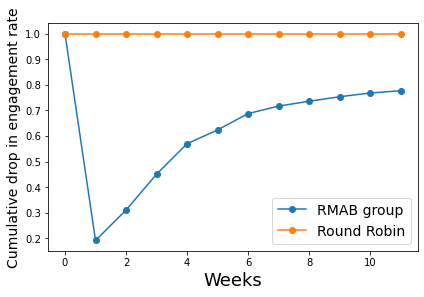

Policy: rmab  value: [1.         0.192      0.31085044 0.45108696 0.57017544 0.62416107
 0.68799472 0.71730874 0.73623853 0.75380914 0.76843198 0.7771394 ]
Policy: round_robin  value: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Policy: control  value: [1 1 1 1 1 1 1 1 1 1 1 1]


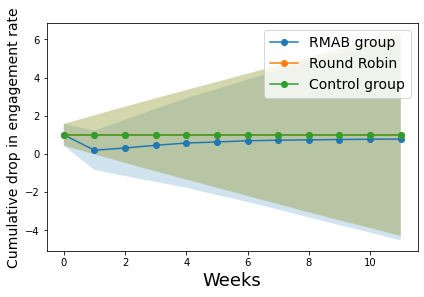

Policy: rmab  value: [0, 90, 224, 259, 299, 427, 492, 622, 742, 853, 1035, 1205]
Policy: round_robin  value: [0, -11, -11, -44, -93, -21, 19, 101, 167, 239, 366, 468]


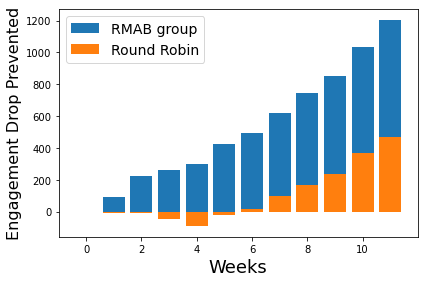

RMAB Raw Engagement Values: [3571, 3547, 3489, 3428, 3300, 3347, 3272, 3292, 3288, 3296, 3231, 3221]
RMAB Cumulative Drop: [0, -24, -106, -249, -520, -744, -1043, -1322, -1605, -1880, -2220, -2570]
RR Raw Engagement Values: [3647, 3522, 3431, 3436, 3287, 3367, 3323, 3320, 3310, 3333, 3252, 3229]
RR Cumulative Drop: [0, -125, -341, -552, -912, -1192, -1516, -1843, -2180, -2494, -2889, -3307]
RMAB - RR  value: [0, 101, 235, 303, 392, 448, 473, 521, 575, 614, 669, 737]


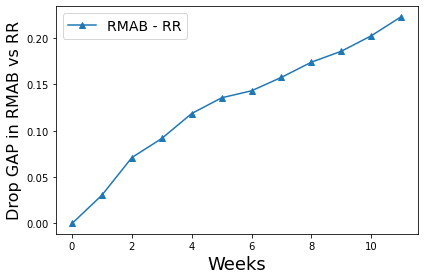

In [12]:
if __name__=="__main__":
    
    parser = argparse.ArgumentParser(description='Inputs to engagement simulator module')
    parser.add_argument('-N', '--num_beneficiaries', default=7000, type=int, help='Number of Beneficiaries')
    parser.add_argument('-k', '--num_resources', default=1400, type=int, help='Number of calls available per day')
    parser.add_argument('-L', '--simulation_length', default=40, type=int, help='Number of timesteps of simulation')
    parser.add_argument('-ntr', '--num_trials', default=10, type=int, help='Number of independent trials')
    parser.add_argument('-s', '--seed_base', default=0, type=int, help='Seedbase for numpy. This is starting seedbase. Simulation will consider the seeds= {seed_base, ... seed_base+ntr-1}')
    parser.add_argument('-p', '--policy', default=-1, type=int, help='policy to run. default is all policies')
    parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
    args = parser.parse_args()

    #T_data,w= loadBeneficiaryData()
    args.num_beneficiaries=T_data.shape[0]
    
    #runRealDataExp(args)
    #runResourcesExp(args)
    #runResourcesExp(args, data='random')
    #runCounterExample(args)
#     makeEngagementPlots(PLOT_OPTION=0)
#     makeEngagementPlots(PLOT_OPTION=1)
    makeEngagementPlots(PLOT_OPTION=0, bool7a=True, T=12)
    

**TEST CODE/UNIT TESTS BELOW**


In [ ]:
T_swapactions[1]

In [ ]:
'''Test code to test out takeActions function'''
states=np.array([0,0,1,1,1])
actions=np.array([0,1,1,1,1])
T1=[[[0.7, 0.1],[0.4,0.6]], [[0.5, 0.5],[0.1,0.95]]]
T2=[[[0.7, 0.15],[0.4,0.6]], [[0.5, 0.5],[0.1,0.96]]]
T3=[[[0.7, 0.2],[0.4,0.6]], [[0.5, 0.5],[0.1,0.97]]]
T=np.array([T1,T2,T3,T2,T1])
for i in range(10):
  #print(takeActions(states, T, actions))
  print(getActions(states, T, 3, policy=4, timestep=40))

In [ ]:
rmab_group_results = pd.read_csv('rmab_pilot.csv')

In [ ]:
rmab_group_results

In [ ]:
#cd 'drive/My\ Drive/ARMMAN/code/'
%cd drive/My\ Drive/ARMMAN/code/

In [ ]:
engagement_matrix.keys()

In [ ]:
actions=np.array([0,0,0,0,1,1])
np.where(actions)[0]
b= np.logical_and(np.ones_like(actions), np.array([0,0,1,1,1,1]))+0
#print(np.sum(actions[actions>0]))

In [ ]:
print (b)
b[np.where((1-actions))[0]]=-100
print(b[np.where((1-actions))[0]])
print (b)
np.where((1-actions))[0]
bk=getTopk(b, 3)

In [ ]:
def get_reward(state, action, m):
    if state[0] == "L":
        reward = 1.0
    else:
        reward = -1.0
    if action == 'N':
        reward += m

    return reward

def convertAxis(T):
    '''
    conver T matrix from format: a, s, s' (where s=0 is bad state) --> s, s', a (where s=0 is good state) 
    '''
    P=np.zeros_like(T)
    for a in range(2):
      for s in range(2):
        for ss in range(2):
          P[1-s,1-ss,a]=T[a,s,ss]
    return P

def plan2(two_state_probs, sleeping_constraint = True ):
    '''
    two_state_probs axes: action, starting_state, final_state. State=1 means engaging state
    '''
    two_state_probs=convertAxis(two_state_probs)

    aug_states = []
    for i in range(6):
        if i % 2 == 0:
            aug_states.append('L{}'.format(i // 2))
        else:
            aug_states.append('H{}'.format(i // 2))

    if sleeping_constraint:
        local_CONFIG = {
            'problem': {
                "orig_states": ['L', 'H'],
                "states": aug_states + ['L', 'H'],
                "actions": ["N", "I"],
            },
            "time_step": 7,
            "gamma": 0.99,
        }
    else:
        local_CONFIG = {
            'problem': {
                "orig_states": ['L', 'H'],
                "states": ['L', 'H'],
                "actions": ["N", "I"],
            },
            "time_step": 7,
            "gamma": 0.99,
        }

    v_values = np.zeros(len(local_CONFIG['problem']['states']))
    q_values = np.zeros((len(local_CONFIG['problem']['states']), len(local_CONFIG['problem']['actions'])))
    high_m_values = 1 * np.ones(len(local_CONFIG['problem']['states']))
    low_m_values = -1 * np.ones(len(local_CONFIG['problem']['states']))

    t_probs = np.zeros((len(local_CONFIG['problem']['states']), len(local_CONFIG['problem']['states']), len(local_CONFIG['problem']['actions'])))

    if sleeping_constraint:    
        t_probs[0 : 2, 2 : 4, 0] = two_state_probs[:, :, 0]
        t_probs[2 : 4, 4 : 6, 0] = two_state_probs[:, :, 0]
        t_probs[4 : 6, 6 : 8, 0] = two_state_probs[:, :, 0]
        t_probs[6 : 8, 6 : 8, 0] = two_state_probs[:, :, 0]

        t_probs[0 : 2, 2 : 4, 1] = two_state_probs[:, :, 0]
        t_probs[2 : 4, 4 : 6, 1] = two_state_probs[:, :, 0]
        t_probs[4 : 6, 6 : 8, 1] = two_state_probs[:, :, 0]
        t_probs[6 : 8, 0 : 2, 1] = two_state_probs[:, :, 1]
    else:
        t_probs = two_state_probs

    max_q_diff = np.inf
    prev_m_values, m_values = None, None
    while max_q_diff > 1e-5:
        prev_m_values = m_values
        m_values = (low_m_values + high_m_values) / 2
        if type(prev_m_values) != type(None) and abs(prev_m_values - m_values).max() < 1e-20:
            break
        max_q_diff = 0
        v_values = np.zeros((len(local_CONFIG['problem']['states'])))
        q_values = np.zeros((len(local_CONFIG['problem']['states']), len(local_CONFIG['problem']['actions'])))
        delta = np.inf
        while delta > 0.0001:
            delta = 0
            for i in range(t_probs.shape[0]):
                v = v_values[i]
                v_a = np.zeros((t_probs.shape[2],))
                for k in range(v_a.shape[0]):
                    for j in range(t_probs.shape[1]):
                        v_a[k] += t_probs[i, j, k] * (get_reward(local_CONFIG['problem']['states'][i], local_CONFIG['problem']['actions'][k], m_values[i]) + local_CONFIG["gamma"] * v_values[j])

                v_values[i] = np.max(v_a)
                delta = max([delta, abs(v_values[i] - v)])

        state_idx = -1
        for state in range(q_values.shape[0]):
            for action in range(q_values.shape[1]):
                for next_state in range(q_values.shape[0]):
                    q_values[state, action] += t_probs[state, next_state, action] * (get_reward(local_CONFIG['problem']['states'][state], local_CONFIG['problem']['actions'][action], m_values[state]) + local_CONFIG["gamma"] * v_values[next_state])
            # print(state, q_values[cluster, state, 0], q_values[cluster, state, 1])

        for state in range(q_values.shape[0]):
            if abs(q_values[state, 1] - q_values[state, 0]) > max_q_diff:
                state_idx = state
                max_q_diff = abs(q_values[state, 1] - q_values[state, 0])

        # print(q_values)
        # print(low_m_values, high_m_values)
        if max_q_diff > 1e-5 and q_values[state_idx, 0] < q_values[state_idx, 1]:
            low_m_values[state_idx] = m_values[state_idx]
        elif max_q_diff > 1e-5 and q_values[state_idx, 0] > q_values[state_idx, 1]:
            high_m_values[state_idx] = m_values[state_idx]

        # print(low_m_values, high_m_values, state_idx)
        # ipdb.set_trace()
    
    m_values = (low_m_values + high_m_values) / 2

    #return q_values, m_values
    return [m_values[-1], m_values[-2]]

In [ ]:
T=np.zeros((1,2,2,2))
N=1
valid_matrix=False
for i in range(N):
  while not valid_matrix:
    Ti=generateRandomTmatrix(1)
    #valid_matrix=verify_T_matrix(Ti[0])
    valid_matrix=True
  T[i]=Ti[0]
plan2(T[0], sleeping_constraint = 'True')

In [ ]:
rmab_group_probs,rmab_group_whittle_indices, engagement_matrix= loadBeneficiaryData()
rmab_group_probs.shape
rmab_group_whittle_indices.shape



In [ ]:
print(rmab_group_probs[0,:,:,:])
print("Indices:", rmab_group_whittle_indices[0])
print("Computed indices:", plan2(rmab_group_probs[0], sleeping_constraint = True))
#print(rmab_group_probs[0,:,:,0])


